In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

for dirname, _, filenames in os.walk("./data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Plant_2_Generation_Data.csv
./data/Plant_1_Generation_Data.csv
./data/Plant_2_Weather_Sensor_Data.csv
./data/Plant_1_Weather_Sensor_Data.csv


## Data Processing


In [95]:
df_plt1_gen = pd.read_csv("./data/Plant_1_Generation_Data.csv")

In [96]:
df_plt1_gen["DATE_TIME"] = pd.to_datetime(df_plt1_gen["DATE_TIME"], dayfirst=True)

# 为了查看每个设备或发电单元（SOURCE_KEY）的记录数量，并按照数量进行排序
df_plt1_gen.groupby("SOURCE_KEY").count().DATE_TIME.sort_values()

SOURCE_KEY
YxYtjZvoooNbGkE    3104
3PZuoBAID5Wc2HD    3118
WRmjgnKYAwPKWDb    3118
adLQvlD726eNBSB    3119
1IF53ai7Xc0U56Y    3119
zBIq5rxdHJRwDNY    3119
ZoEaEvLYb1n2sOq    3123
sjndEbLyjtCKgGv    3124
rGa61gmuvPhdLxV    3124
zVJPv84UY57bAof    3124
McdE0feGgRqW7Ca    3124
iCRJl6heRkivqQ3    3125
pkci93gMrogZuBj    3125
uHbuxQJl8lW7ozc    3125
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
VHMLBKoKgIrUVDU    3133
7JYdWkrLSPkdwr4    3133
1BY6WEcLGh8j5v7    3154
bvBOhCH3iADSZry    3155
Name: DATE_TIME, dtype: int64

In [97]:
d1 = df_plt1_gen["DATE_TIME"].unique()
print(d1.shape)

d2 = df_plt1_gen[df_plt1_gen["SOURCE_KEY"] == "1BY6WEcLGh8j5v7"]["DATE_TIME"].unique()
print(d2.shape)

df1 = pd.DataFrame(d1)
df2 = pd.DataFrame(d2)

(3158,)
(3154,)


In [98]:
df_plt1_weather = pd.read_csv("./data/Plant_1_Weather_Sensor_Data.csv")

df_plt1_weather.describe(include="all").T

df_weather = df_plt1_weather.drop(["PLANT_ID", "SOURCE_KEY"], axis=1)

df_weather["DATE_TIME"] = pd.to_datetime(
    df_weather.DATE_TIME, format="%Y-%m-%d %H:%M:%S"
)

In [99]:
# datetimes_full 这个序列表示从数据集中最早的时间到最晚的时间，以15分钟为间隔的完整时间序列。这个完整时间序列包括了可能在原始天气数据中未出现的时间点，有助于识别数据集中的时间间隙
datetimes_w = df_weather["DATE_TIME"].unique()

datetimes_full = pd.Series(
    pd.date_range(df_weather.DATE_TIME.min(), df_weather.DATE_TIME.max(), freq="15min"),
    name="DATE_TIME",
)
datetimes_full

0      2020-05-15 00:00:00
1      2020-05-15 00:15:00
2      2020-05-15 00:30:00
3      2020-05-15 00:45:00
4      2020-05-15 01:00:00
               ...        
3259   2020-06-17 22:45:00
3260   2020-06-17 23:00:00
3261   2020-06-17 23:15:00
3262   2020-06-17 23:30:00
3263   2020-06-17 23:45:00
Name: DATE_TIME, Length: 3264, dtype: datetime64[ns]

In [100]:
# sourceKey -> inverter
df_gen = df_plt1_gen.drop("PLANT_ID", axis=1)
df_gen["INVERTER"] = df_gen.SOURCE_KEY.map(
    {
        df_gen.SOURCE_KEY.unique()[i - 1]: f"INVERTER_{i}"
        for i in range(1, len(df_gen.SOURCE_KEY.unique()) + 1)
    }
)
df_gen = df_gen.drop("SOURCE_KEY", axis=1)
inverters = df_gen.INVERTER.unique()
inverters

array(['INVERTER_1', 'INVERTER_2', 'INVERTER_3', 'INVERTER_4',
       'INVERTER_5', 'INVERTER_6', 'INVERTER_7', 'INVERTER_8',
       'INVERTER_9', 'INVERTER_10', 'INVERTER_11', 'INVERTER_12',
       'INVERTER_13', 'INVERTER_14', 'INVERTER_15', 'INVERTER_16',
       'INVERTER_17', 'INVERTER_18', 'INVERTER_19', 'INVERTER_20',
       'INVERTER_21', 'INVERTER_22'], dtype=object)

In [101]:
# 整合和填充每个逆变器在完整时间序列上的数据，确保数据集包含每个时间点上所有逆变器的记录，即使某些时间点上没有实际的发电数据
dfs_gen = []
for i in inverters:
    df_inverter = df_gen[df_gen.INVERTER == i]
    df_inverter = df_inverter.merge(datetimes_full, on="DATE_TIME", how="right")
    df_inverter["INVERTER"] = i
    dfs_gen.append(df_inverter)
df_gen = pd.concat(dfs_gen)

In [102]:
df = df_gen.merge(df_weather, on="DATE_TIME", how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 71807
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   DC_POWER             68778 non-null  float64       
 2   AC_POWER             68778 non-null  float64       
 3   DAILY_YIELD          68778 non-null  float64       
 4   TOTAL_YIELD          68778 non-null  float64       
 5   INVERTER             71808 non-null  object        
 6   AMBIENT_TEMPERATURE  70004 non-null  float64       
 7   MODULE_TEMPERATURE   70004 non-null  float64       
 8   IRRADIATION          70004 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 5.5+ MB


In [103]:
df["HOUR"] = df.DATE_TIME.dt.hour
df["DAY"] = df.DATE_TIME.dt.dayofyear
df["DAY_WEEK"] = df.DATE_TIME.dt.dayofweek
df["MINUTES_15"] = df.DATE_TIME.dt.time

# This maps the 15 minute intervals over the course of the day to ints 1-96.
df["MINUTES_15"] = df.MINUTES_15.map(
    {df.MINUTES_15.unique()[i - 1]: i for i in range(1, 97)}
)
# Change day of year to day of data
df["DAY"] = df.DAY.map({df.DAY.unique()[i - 1]: i for i in range(1, 35)})

print(df.shape, df.head())

(71808, 13)             DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15 00:00:00       0.0       0.0          0.0    6259559.0   
1 2020-05-15 00:15:00       0.0       0.0          0.0    6259559.0   
2 2020-05-15 00:30:00       0.0       0.0          0.0    6259559.0   
3 2020-05-15 00:45:00       0.0       0.0          0.0    6259559.0   
4 2020-05-15 01:00:00       0.0       0.0          0.0    6259559.0   

     INVERTER  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  HOUR  \
0  INVERTER_1            25.184316           22.857507          0.0     0   
1  INVERTER_1            25.084589           22.761668          0.0     0   
2  INVERTER_1            24.935753           22.592306          0.0     0   
3  INVERTER_1            24.846130           22.360852          0.0     0   
4  INVERTER_1            24.621525           22.165423          0.0     1   

   DAY  DAY_WEEK  MINUTES_15  
0    1         4           1  
1    1         4           2  
2    

<Axes: >

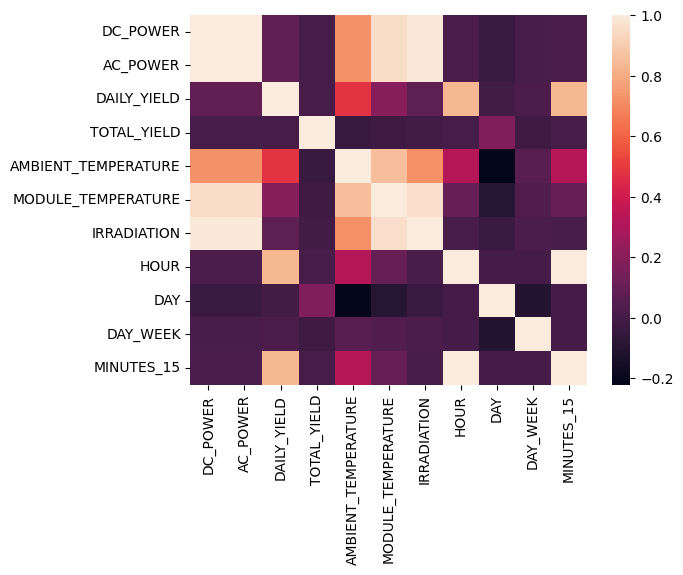

In [104]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr)

## Data Picking


In [105]:
inverter_example = "INVERTER_1"

sample_data = df[df["INVERTER"] == inverter_example]

missing_values = sample_data.isnull().sum()
print(missing_values)

sample_data.fillna(method="ffill", inplace=True)

print(sample_data.head())

missing_values = sample_data.isnull().sum()
print(missing_values)

DATE_TIME                0
DC_POWER               110
AC_POWER               110
DAILY_YIELD            110
TOTAL_YIELD            110
INVERTER                 0
AMBIENT_TEMPERATURE     82
MODULE_TEMPERATURE      82
IRRADIATION             82
HOUR                     0
DAY                      0
DAY_WEEK                 0
MINUTES_15               0
dtype: int64
            DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15 00:00:00       0.0       0.0          0.0    6259559.0   
1 2020-05-15 00:15:00       0.0       0.0          0.0    6259559.0   
2 2020-05-15 00:30:00       0.0       0.0          0.0    6259559.0   
3 2020-05-15 00:45:00       0.0       0.0          0.0    6259559.0   
4 2020-05-15 01:00:00       0.0       0.0          0.0    6259559.0   

     INVERTER  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  HOUR  \
0  INVERTER_1            25.184316           22.857507          0.0     0   
1  INVERTER_1            25.084589           22.761668 

/var/folders/mf/1zht4rt167l4nwkf7l1df8rh0000gn/T/ipykernel_79756/3539397373.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data.fillna(method="ffill", inplace=True)


<Axes: >

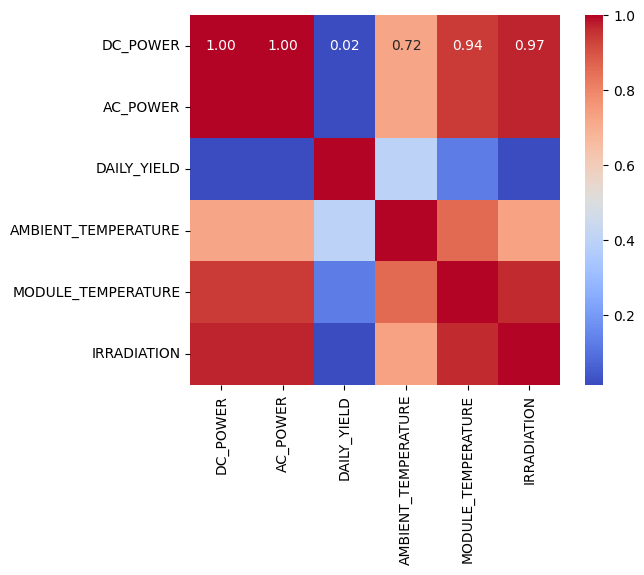

In [106]:
relevant_columns = [
    "DC_POWER",
    "AC_POWER",
    "DAILY_YIELD",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
]

correlation_matrix_1 = sample_data[relevant_columns].corr()
sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm", fmt=".2f", square=True)

## Prediction


In [107]:
# Preparing features and target variable
features = sample_data[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = sample_data["AC_POWER"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2611, 3) (2611,)
(653, 3) (653,)


In [108]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, y_train.shape)

(2611, 3) (2611,)


### SVM


In [109]:
# SVM Model Training
svm_model = SVR(kernel="rbf")
svm_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
svm_score = svm_model.score(X_test_scaled, y_test) * 100
svm_r2 = r2_score(y_test, y_pred_svm) * 100
mse_svm = mean_squared_error(y_test, y_pred_svm)

print(f"SVM Model score = {svm_score:4.4f}%")
print(f"SVM Model R^2 = {svm_r2:4.4f}")
print(f"SVM Model MSE = {mse_svm:4.4f}")

SVM Model score = 83.9290%
SVM Model R^2 = 83.9290
SVM Model MSE = 21214.3493


### GBDT


In [110]:
# GBDT Model Training
gbdt_model = GradientBoostingRegressor()
gbdt_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_gbdt = gbdt_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
gbdt_score = gbdt_model.score(X_test_scaled, y_test) * 100
gbdt_r2_score = r2_score(y_test, y_pred_gbdt) * 100
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)

print(f"GBDT Model score = {gbdt_score:4.4f}%")
print(f"GBDT Model R^2 score = {gbdt_r2_score:4.4f}")
print(f"GBDT Model MSE = {mse_gbdt:4.4f}")

GBDT Model score = 91.6700%
GBDT Model R^2 score = 91.6700
GBDT Model MSE = 10995.9158


### NNet


In [111]:
X_train_torch = torch.tensor(X_train_scaled.astype(np.float32))
y_train_torch = torch.tensor(y_train.values.astype(np.float32))
X_test_torch = torch.tensor(X_test_scaled.astype(np.float32))
y_test_torch = torch.tensor(y_test.values.astype(np.float32))


train_data = TensorDataset(X_train_torch, y_train_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [112]:
class NNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x


model = NNet(3, 128, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

nnet_r2 = r2_score(targets, predictions) * 100
print(f"NNet R^2 Score: {nnet_r2}")

Epoch 1, Loss: 266858.625
Epoch 2, Loss: 227767.0625
Epoch 3, Loss: 145474.59375
Epoch 4, Loss: 55194.4296875
Epoch 5, Loss: 18783.685546875
Epoch 6, Loss: 35497.17578125
Epoch 7, Loss: 13306.943359375
Epoch 8, Loss: 9546.134765625
Epoch 9, Loss: 3714.64794921875
Epoch 10, Loss: 2571.370361328125
Epoch 11, Loss: 3009.818603515625
Epoch 12, Loss: 9104.8740234375
Epoch 13, Loss: 1670.4481201171875
Epoch 14, Loss: 2894.177734375
Epoch 15, Loss: 3475.39990234375
Epoch 16, Loss: 1121.8330078125
Epoch 17, Loss: 8656.8349609375
Epoch 18, Loss: 2529.08544921875
Epoch 19, Loss: 8803.7158203125
Epoch 20, Loss: 3971.9833984375
Epoch 21, Loss: 50134.9609375
Epoch 22, Loss: 531.469970703125
Epoch 23, Loss: 16315.826171875
Epoch 24, Loss: 1968.0770263671875
Epoch 25, Loss: 2649.1474609375
Epoch 26, Loss: 27462.693359375
Epoch 27, Loss: 1340.98779296875
Epoch 28, Loss: 7018.14599609375
Epoch 29, Loss: 9907.103515625
Epoch 30, Loss: 2023.1573486328125
Epoch 31, Loss: 15189.0439453125
Epoch 32, Loss: 1

In [113]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2out = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.hidden2out(lstm_out.view(len(input), -1))
        return output


model = LSTM(3, 128, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

lstm_r2 = r2_score(targets, predictions) * 100
print(f"LSTM R^2 Score: {lstm_r2}")

Epoch 1, Loss: 185292.125
Epoch 2, Loss: 219636.984375
Epoch 3, Loss: 180559.0625
Epoch 4, Loss: 170245.484375
Epoch 5, Loss: 192856.140625
Epoch 6, Loss: 212862.828125
Epoch 7, Loss: 187416.296875
Epoch 8, Loss: 256848.0
Epoch 9, Loss: 144344.125
Epoch 10, Loss: 164096.90625
Epoch 11, Loss: 54463.078125
Epoch 12, Loss: 179871.90625
Epoch 13, Loss: 154399.953125
Epoch 14, Loss: 142634.5625
Epoch 15, Loss: 214145.484375
Epoch 16, Loss: 261506.203125
Epoch 17, Loss: 149397.25
Epoch 18, Loss: 123107.2578125
Epoch 19, Loss: 137230.5625
Epoch 20, Loss: 154427.6875
Epoch 21, Loss: 150752.171875
Epoch 22, Loss: 172288.90625
Epoch 23, Loss: 114542.8984375
Epoch 24, Loss: 225903.75
Epoch 25, Loss: 149655.765625
Epoch 26, Loss: 92106.9609375
Epoch 27, Loss: 142033.125
Epoch 28, Loss: 193894.59375
Epoch 29, Loss: 173540.40625
Epoch 30, Loss: 100066.84375
Epoch 31, Loss: 110855.9921875
Epoch 32, Loss: 152573.4375
Epoch 33, Loss: 140464.4375
Epoch 34, Loss: 113830.375
Epoch 35, Loss: 198731.21875
E